# 安徽安庆市项目`WRF-CMAQ`模拟分析
## Spatial Distribution : `chem-obs data`

---
*@author: Evan*\
*@date: 2023-03-29*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

## 读取数据

In [2]:
chemFile=xr.open_dataset('F:/Data/case_anqing/compressed_chem.nc')
metFile=xr.open_dataset('F:/Data/case_anqing/compressed_met.nc')

In [13]:
lat=chemFile.latitude
lon=chemFile.longitude

O3_L1=np.squeeze(chemFile.O3.sel(level=1000,method='nearest'))
O3_L2=np.squeeze(chemFile.O3.sel(level=850,method='nearest'))

uw_L1=np.squeeze(metFile.uwind.sel(level=1000,method='nearest'))
vw_L1=np.squeeze(metFile.vwind.sel(level=1000,method='nearest'))

uw_L2=np.squeeze(metFile.uwind.sel(level=850,method='nearest'))
vw_L2=np.squeeze(metFile.vwind.sel(level=850,method='nearest'))

print('lat & lon = ',lat.shape)
print('chem      = ',O3_L1.shape)

lat & lon =  (138, 135)
chem      =  (672, 138, 135)


In [14]:
# calculate MDA8 O3
mda8_L1 = O3_L1.rolling(time=8).mean().resample({'time':'D'}).max(dim='time')
mda8_L2 = O3_L2.rolling(time=8).mean().resample({'time':'D'}).max(dim='time')

In [5]:
# calculate average uv wind
uuL1 = uw_L1.resample({'time':'D'}).mean(dim='time')
vvL1 = vw_L1.resample({'time':'D'}).mean(dim='time')

uuL2 = uw_L2.resample({'time':'D'}).mean(dim='time')
vvL2 = vw_L2.resample({'time':'D'}).mean(dim='time')

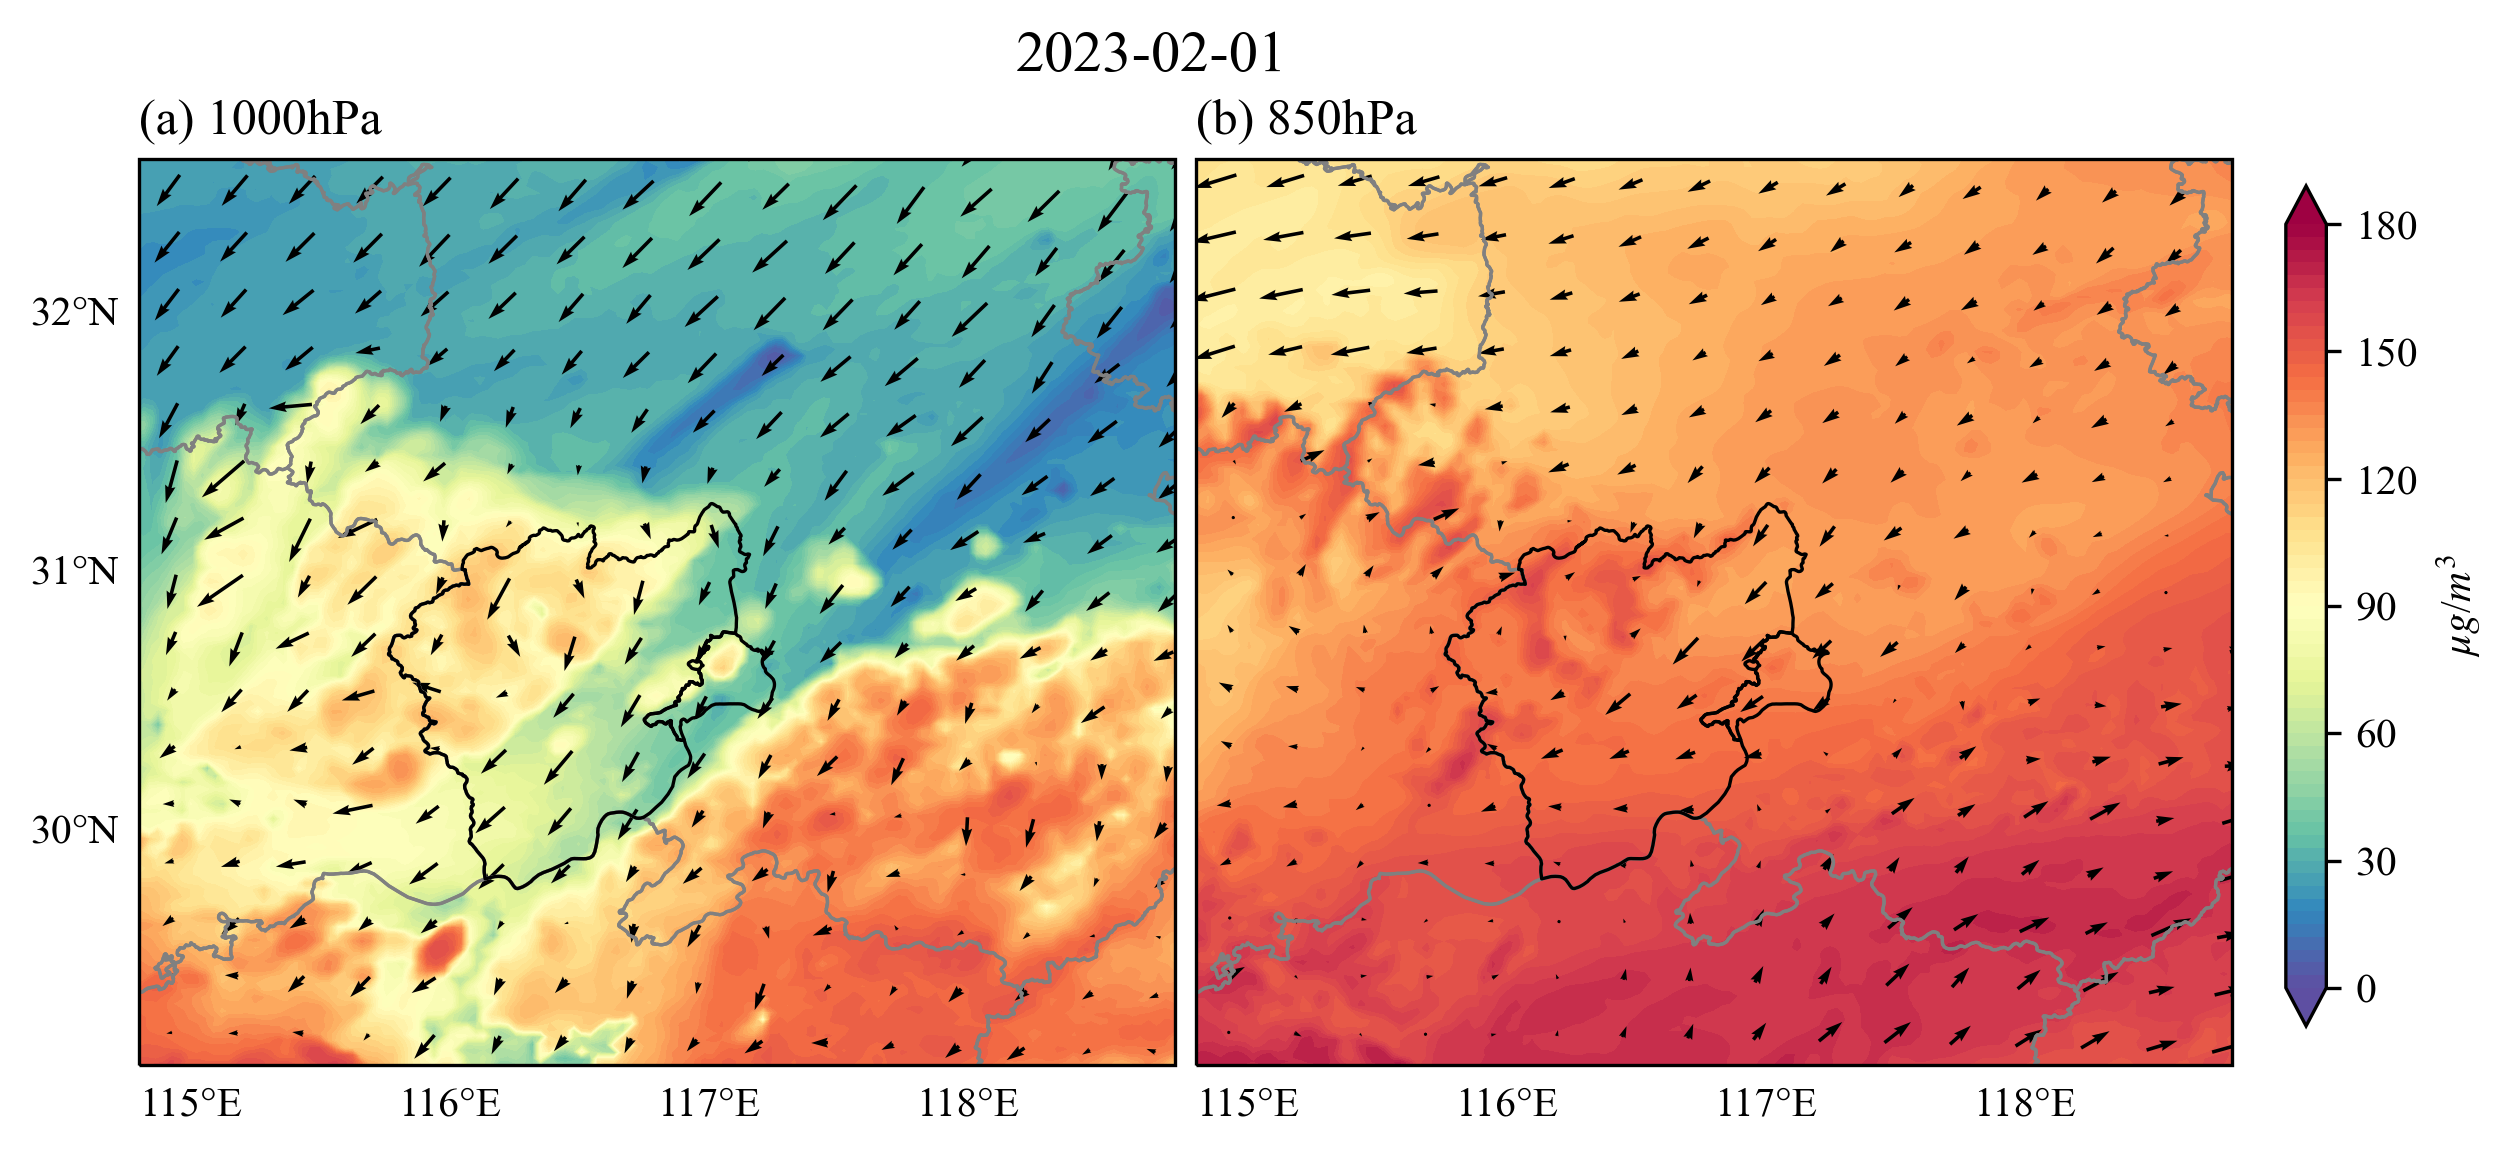

In [16]:
date=1
cmax=181
cmaplevel=np.arange(0,cmax,3)
proj=ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
ax = fig.subplots(1,2,subplot_kw={'projection':proj})

shp_urban = Reader('F:/Data/case_anqing/shapefile/Anqing_urban/urban.shp')
shp_rural = Reader('F:/Data/case_anqing/shapefile/Anqing_rural/rural.shp')
shp_pro = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/2. Province/province.shp')
for i in range(2):
    ax[i].add_feature(cfeat.ShapelyFeature(shp_pro.geometries(),proj,edgecolor='gray',facecolor='None'), linewidth=0.8)
    ax[i].add_feature(cfeat.ShapelyFeature(shp_urban.geometries(),proj,edgecolor='k',facecolor='None'), linewidth=0.8)
    ax[i].add_feature(cfeat.ShapelyFeature(shp_rural.geometries(),proj,edgecolor='k',facecolor='None'), linewidth=0.8)

    gl=ax[i].gridlines(
        xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
        draw_labels=True, x_inline=False, y_inline=False,
        linewidth=0, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels =False
    gl.rotate_labels=False
    
    ax[i].set_extent([114.8, 118.8, 29.1, 32.6],ccrs.PlateCarree()) # d03
#     ax[i].set_extent([115.6, 117.4, 29.7, 31.4],ccrs.PlateCarree()) # anqing

    if i>0:
        gl.left_labels=False

xgrid=np.size(uuL1,2)
ygrid=np.size(vvL1,1)
ngrid=8

# contour map
cmap=ax[0].contourf(lon,lat,mda8_L1[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')
cmap=ax[1].contourf(lon,lat,mda8_L2[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')

# wind quiver
ax[0].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
        uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
        transform=proj,color='k',alpha=1,scale=150,headwidth=3)
ax[1].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
        uuL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
        transform=proj,color='k',alpha=1,scale=150,headwidth=3)

# station obs
# for m in range(100):
#     ax[0].scatter(sites_lon[m],sites_lat[m],transform=proj_shp,marker='o',s=20,
#                   c=O3_obs_mda[0,m],cmap='Spectral_r',vmin=0,vmax=cmax,edgecolors='k',linewidth=0.5)

# share colorbar
fig.subplots_adjust(right=0.9,wspace=0.02)
position= fig.add_axes([0.92,0.15,0.015,0.7])
cbar=fig.colorbar(cmap,cax=position)
cbar.set_ticks(np.arange(0,cmax+1,30))
cbar.set_label('$\mu$$g$/$m^3$')

ax[0].set_title('(a) 1000hPa',loc='left')
ax[1].set_title('(b) 850hPa',loc='left')
plt.suptitle(pd.to_datetime('2023-02-'+str(date)).strftime('%Y-%m-%d'),size=14)

plt.show()

In [9]:
dates=np.arange(1,29)
cmax=181
cmaplevel=np.arange(0,cmax,3)
proj=ccrs.PlateCarree()
for date in dates:
        fig = plt.figure(figsize=(9,4),dpi=300)
        ax = fig.subplots(1,2,subplot_kw={'projection':proj})

        shp_urban = Reader('F:/Data/case_anqing/shapefile/Anqing_urban/urban.shp')
        shp_rural = Reader('F:/Data/case_anqing/shapefile/Anqing_rural/rural.shp')
        shp_pro = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/2. Province/province.shp')
        for i in range(2):
                ax[i].add_feature(cfeat.ShapelyFeature(shp_pro.geometries(),proj,edgecolor='gray',facecolor='None'), linewidth=0.8)
                ax[i].add_feature(cfeat.ShapelyFeature(shp_urban.geometries(),proj,edgecolor='k',facecolor='None'), linewidth=0.8)
                ax[i].add_feature(cfeat.ShapelyFeature(shp_rural.geometries(),proj,edgecolor='k',facecolor='None'), linewidth=0.8)

                gl=ax[i].gridlines(
                        xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
                        draw_labels=True, x_inline=False, y_inline=False,
                        linewidth=0, linestyle='--', color='gray')
                gl.top_labels = False
                gl.right_labels =False
                gl.rotate_labels=False
        
                ax[i].set_extent([114.8, 118.8, 29.1, 32.6],ccrs.PlateCarree()) # d03
                # ax[i].set_extent([115.6, 117.4, 29.7, 31.4],ccrs.PlateCarree()) # anqing

                if i>0:
                        gl.left_labels=False

        xgrid=np.size(uuL1,2)
        ygrid=np.size(vvL1,1)
        ngrid=8

        # contour map
        cmap=ax[0].contourf(lon,lat,mda8_L1[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')
        cmap=ax[1].contourf(lon,lat,mda8_L2[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')

        # wind quiver
        ax[0].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
                uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
                transform=proj,color='k',alpha=1,scale=150,headwidth=3)
        ax[1].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
                uuL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
                transform=proj,color='k',alpha=1,scale=150,headwidth=3)

        # station obs
        # for m in range(100):
        #     ax[0].scatter(sites_lon[m],sites_lat[m],transform=proj_shp,marker='o',s=20,
        #                   c=O3_obs_mda[0,m],cmap='Spectral_r',vmin=0,vmax=cmax,edgecolors='k',linewidth=0.5)

        # share colorbar
        fig.subplots_adjust(right=0.9,wspace=0.02)
        position= fig.add_axes([0.92,0.15,0.015,0.7])
        cbar=fig.colorbar(cmap,cax=position)
        cbar.set_ticks(np.arange(0,cmax+1,30))
        cbar.set_label('$\mu$$g$/$m^3$')

        ax[0].set_title('(a) 1000hPa',loc='left')
        ax[1].set_title('(b) 850hPa',loc='left')
        plt.suptitle(pd.to_datetime('2023-02-'+str(date)).strftime('%Y-%m-%d'),size=14)

        plt.savefig('D:/Download/MDA8_'+pd.to_datetime('2023-02-'+str(date)).strftime('%Y-%m-%d'))
        print('saving MDA8 on '+pd.to_datetime('2023-02-'+str(date)).strftime('%Y-%m-%d'))
# plt.show()

saving MDA8 on 2023-02-01
saving MDA8 on 2023-02-02
saving MDA8 on 2023-02-03
saving MDA8 on 2023-02-04
saving MDA8 on 2023-02-05
saving MDA8 on 2023-02-06
saving MDA8 on 2023-02-07
saving MDA8 on 2023-02-08
saving MDA8 on 2023-02-09
saving MDA8 on 2023-02-10
saving MDA8 on 2023-02-11
saving MDA8 on 2023-02-12
saving MDA8 on 2023-02-13
saving MDA8 on 2023-02-14
saving MDA8 on 2023-02-15
saving MDA8 on 2023-02-16
saving MDA8 on 2023-02-17
saving MDA8 on 2023-02-18
saving MDA8 on 2023-02-19
saving MDA8 on 2023-02-20
saving MDA8 on 2023-02-21
saving MDA8 on 2023-02-22
saving MDA8 on 2023-02-23
saving MDA8 on 2023-02-24
saving MDA8 on 2023-02-25
saving MDA8 on 2023-02-26
saving MDA8 on 2023-02-27
saving MDA8 on 2023-02-28


---
## 加入观测站资料，范围缩小为安庆市

In [17]:
# read site lat and lon
sites = pd.read_excel('D:/files/Master/02学术/横向项目_安庆/data/安庆市站点坐标.xlsx',header=0,usecols=['站点名称','经度','纬度'])
sites

,站点名称,经度,纬度
0,安庆大学,116.98980,30.61460
1,市人大,117.05970,30.53510
2,环科院,117.08070,30.51770
3,马山宾馆,117.03310,30.51190
4,怀宁县青妇活动中心,116.82210,30.73840
5,怀宁县振宁学校,116.83805,30.74083
6,潜山市档案馆,116.57450,30.63250
7,潜山市公路局,116.55390,30.64220
8,太湖县龙山路240号,116.31330,30.45710
9,太湖县职业技术学校,116.31240,30.44490


In [18]:
# read obs ozone concentration
# directory containing the Excel files
dir_path = 'F:/Data/case_anqing/obs_202302_fromlzj/all/'

# create an empty dataframe to store the data
df = pd.DataFrame()

# loop through each file in the directory
for filename in os.listdir(dir_path):
    if filename.endswith('.xlsx'): # make sure it's an Excel file
        # read the Excel file into a dataframe and set the first column as the index
        file_path = os.path.join(dir_path, filename)
        temp_df = pd.read_excel(file_path, index_col=0)
        
        # extract the 'O3' column and add it to the main dataframe
        col_name = os.path.splitext(filename)[0] # use the file name as the column name
        df[col_name] = temp_df['O3']

# print the final dataframe
df.shape

(672, 19)

In [19]:
# calculate observation MDA8 ozone
mda8_obs = df.rolling(8).mean().resample('D').max()
mda8_obs.shape

(28, 19)

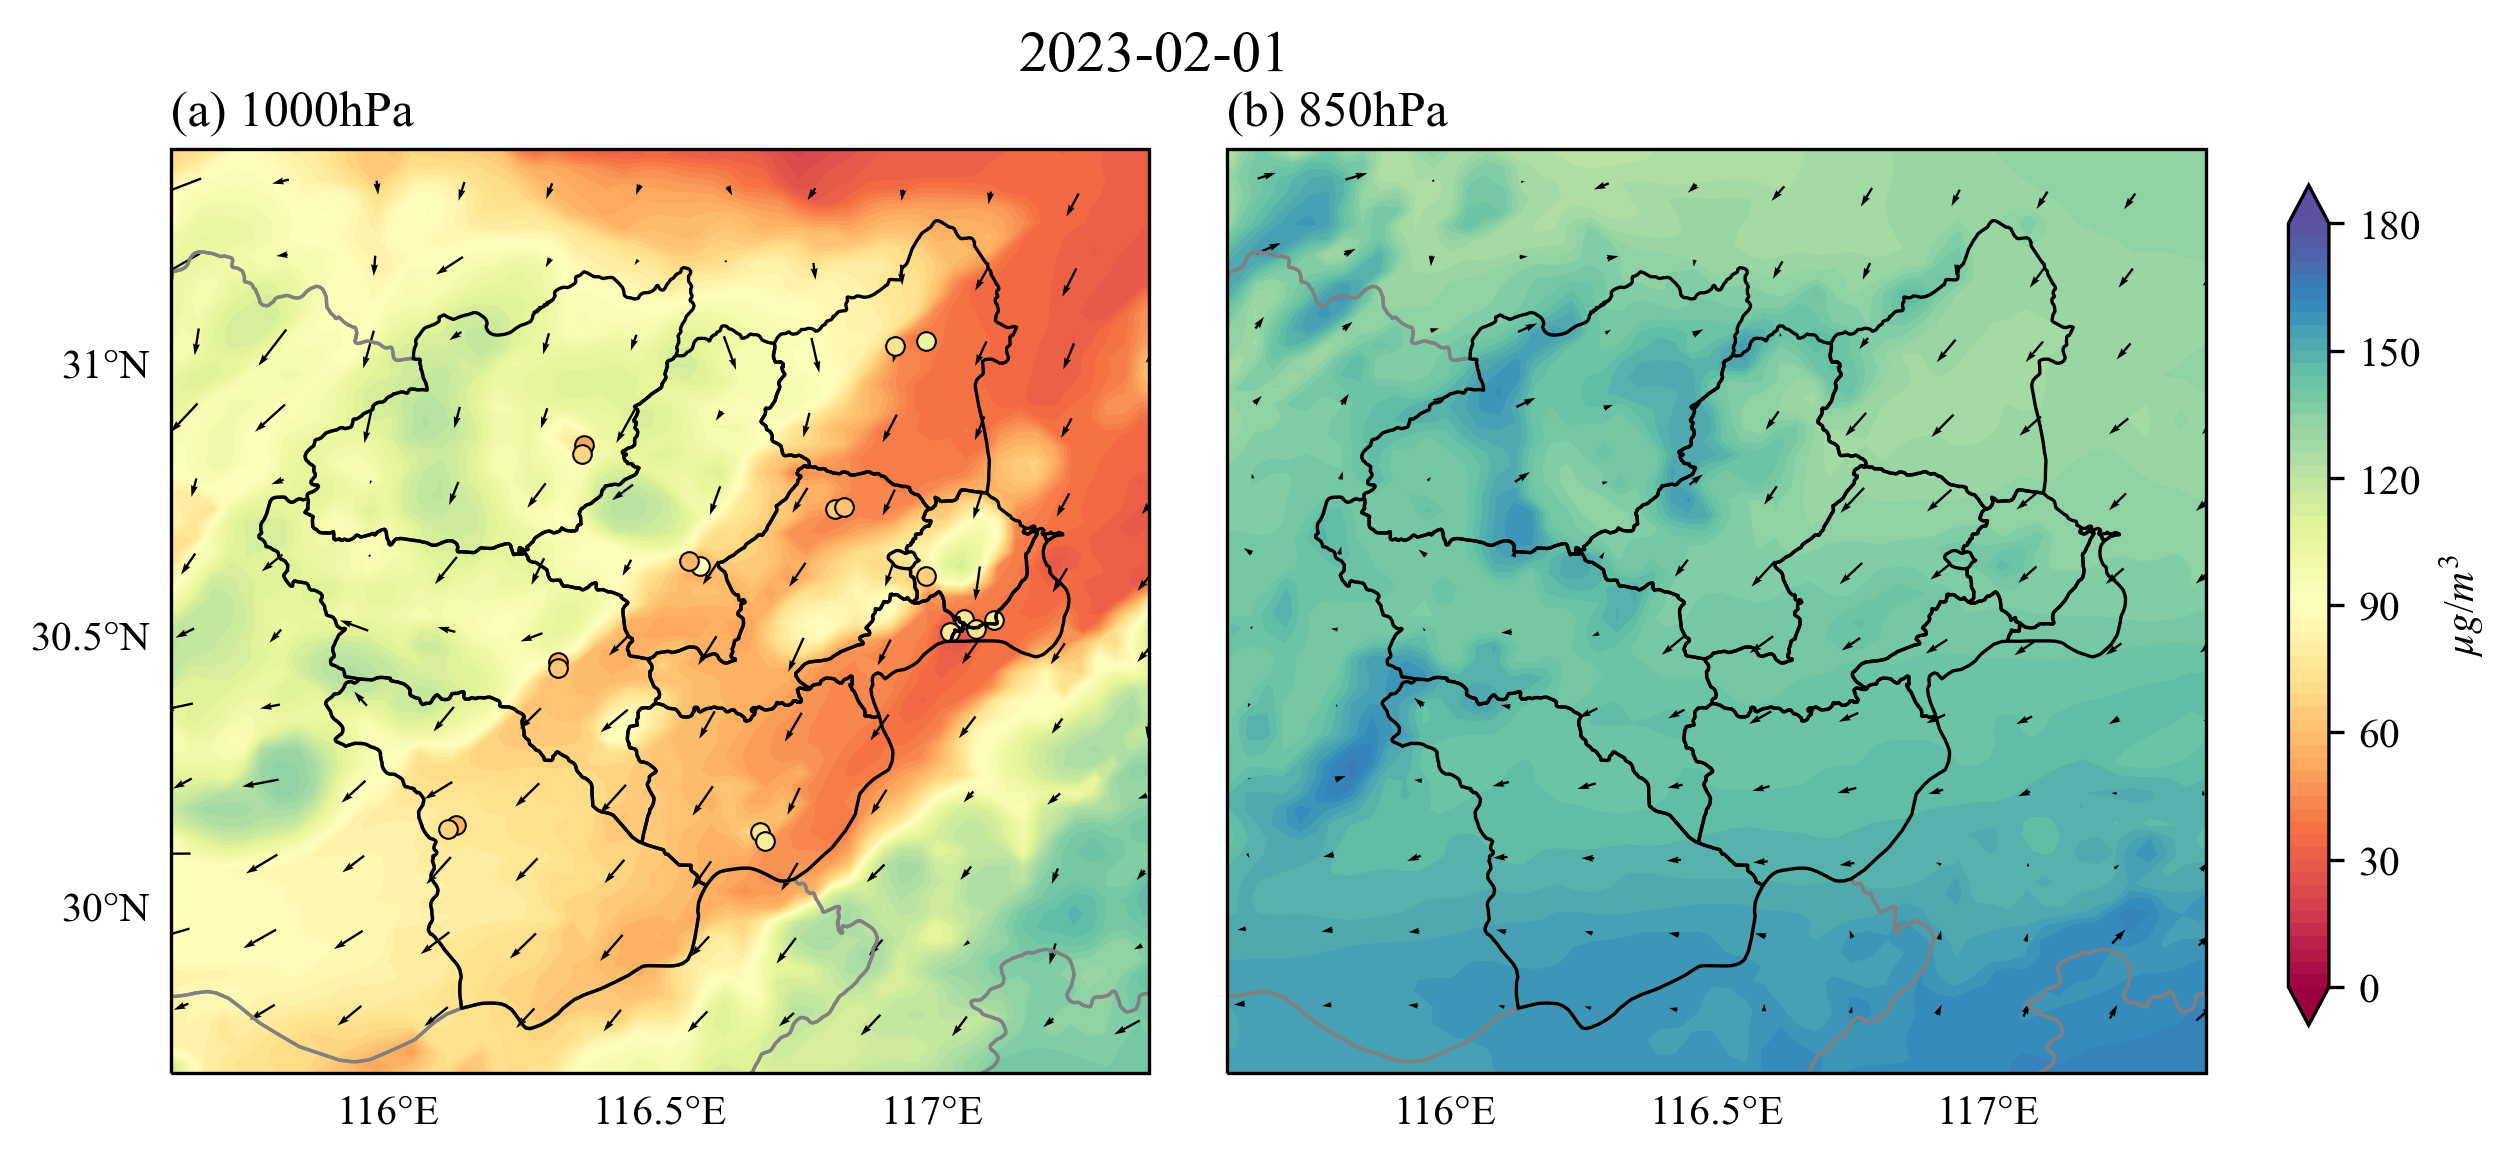

In [21]:
date=1
cmax=181
cmaplevel=np.arange(0,cmax,3)
proj=ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
ax = fig.subplots(1,2,subplot_kw={'projection':proj})

shp_aq = Reader('F:/Data/case_anqing/shapefile/Anqing_district/anqing_district.shp')
shp_pro = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/2. Province/province.shp')
for i in range(2):
    ax[i].add_feature(cfeat.ShapelyFeature(shp_pro.geometries(),proj,edgecolor='gray',facecolor='None'), linewidth=0.8)
    ax[i].add_feature(cfeat.ShapelyFeature(shp_aq.geometries(),proj,edgecolor='k',facecolor='None'), linewidth=0.8)

    gl=ax[i].gridlines(
        xlocs=np.arange(-180, 180 + 1, 0.5), ylocs=np.arange(-90, 90 + 1, 0.5),
        draw_labels=True, x_inline=False, y_inline=False,
        linewidth=0, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels =False
    gl.rotate_labels=False
    
    # ax[i].set_extent([114.8, 118.8, 29.1, 32.6],ccrs.PlateCarree()) # d03
    ax[i].set_extent([115.6, 117.4, 29.7, 31.4],ccrs.PlateCarree()) # anqing

    if i>0:
        gl.left_labels=False

xgrid=np.size(uuL1,2)
ygrid=np.size(vvL1,1)
ngrid=5 # 8 for d03

# contour map
cmap=ax[0].contourf(lon,lat,mda8_L1[date-1,:,:],transform=proj,cmap='Spectral',levels=cmaplevel,extend='both')
cmap=ax[1].contourf(lon,lat,mda8_L2[date-1,:,:],transform=proj,cmap='Spectral',levels=cmaplevel,extend='both')

# wind quiver
ax[0].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
        uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
        transform=proj,color='k',alpha=1,scale=150,headwidth=3)
ax[1].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
        uuL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
        transform=proj,color='k',alpha=1,scale=150,headwidth=3)

# station obs
for m in range(np.size(df.columns)):
    sitename = sites['站点名称'][m]
    ax[0].scatter(sites['经度'][m],sites['纬度'][m],transform=proj,marker='o',s=20,
                  c=mda8_obs[sitename][date-1],cmap='Spectral_r',vmin=0,vmax=cmax,edgecolors='k',linewidth=0.5)

# share colorbar
fig.subplots_adjust(right=0.9,wspace=0.02)
position= fig.add_axes([0.92,0.15,0.015,0.7])
cbar=fig.colorbar(cmap,cax=position)
cbar.set_ticks(np.arange(0,cmax+1,30))
cbar.set_label('$\mu$$g$/$m^3$')

ax[0].set_title('(a) 1000hPa',loc='left')
ax[1].set_title('(b) 850hPa',loc='left')
plt.suptitle(pd.to_datetime('2023-02-'+str(date)).strftime('%Y-%m-%d'),size=14)

plt.show()

In [22]:
dates=np.arange(1,29)
cmax=181
cmaplevel=np.arange(0,cmax,3)
proj=ccrs.PlateCarree()

for date in dates:
    fig = plt.figure(figsize=(9,4),dpi=300)
    ax = fig.subplots(1,2,subplot_kw={'projection':proj})

    shp_aq = Reader('F:/Data/case_anqing/shapefile/Anqing_district/anqing_district.shp')
    shp_pro = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/2. Province/province.shp')
    for i in range(2):
        ax[i].add_feature(cfeat.ShapelyFeature(shp_pro.geometries(),proj,edgecolor='gray',facecolor='None'), linewidth=0.8)
        ax[i].add_feature(cfeat.ShapelyFeature(shp_aq.geometries(),proj,edgecolor='k',facecolor='None'), linewidth=0.8)

        gl=ax[i].gridlines(
            xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
            draw_labels=True, x_inline=False, y_inline=False,
            linewidth=0, linestyle='--', color='gray')
        gl.top_labels = False
        gl.right_labels =False
        gl.rotate_labels=False
        
        # ax[i].set_extent([114.8, 118.8, 29.1, 32.6],ccrs.PlateCarree()) # d03
        ax[i].set_extent([115.6, 117.4, 29.7, 31.4],ccrs.PlateCarree()) # anqing

        if i>0:
            gl.left_labels=False

    xgrid=np.size(uuL1,2)
    ygrid=np.size(vvL1,1)
    ngrid=5 # 8 for d03

    # contour map
    cmap=ax[0].contourf(lon,lat,mda8_L1[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')
    cmap=ax[1].contourf(lon,lat,mda8_L2[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')

    # wind quiver
    ax[0].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
            uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
            transform=proj,color='k',alpha=1,scale=150,headwidth=3)
    ax[1].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
            uuL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
            transform=proj,color='k',alpha=1,scale=150,headwidth=3)

    # station obs
    for m in range(np.size(df.columns)):
        sitename = sites['站点名称'][m]
        ax[0].scatter(sites['经度'][m],sites['纬度'][m],transform=proj,marker='o',s=20,
                    c=mda8_obs[sitename][date-1],cmap='Spectral_r',vmin=0,vmax=cmax,edgecolors='k',linewidth=0.5)

    # share colorbar
    fig.subplots_adjust(right=0.9,wspace=0.02)
    position= fig.add_axes([0.92,0.15,0.015,0.7])
    cbar=fig.colorbar(cmap,cax=position)
    cbar.set_ticks(np.arange(0,cmax+1,30))
    cbar.set_label('$\mu$$g$/$m^3$')

    ax[0].set_title('(a) 1000hPa',loc='left')
    ax[1].set_title('(b) 850hPa',loc='left')
    plt.suptitle(pd.to_datetime('2023-02-'+str(date)).strftime('%Y-%m-%d'),size=14)

    plt.savefig('D:/Download/MDA8_obs_'+pd.to_datetime('2023-02-'+str(date)).strftime('%Y-%m-%d'))
    print('saving MDA8 on '+pd.to_datetime('2023-02-'+str(date)).strftime('%Y-%m-%d'))


saving MDA8 on 2023-02-01
saving MDA8 on 2023-02-02
saving MDA8 on 2023-02-03
saving MDA8 on 2023-02-04
saving MDA8 on 2023-02-05
saving MDA8 on 2023-02-06
saving MDA8 on 2023-02-07
saving MDA8 on 2023-02-08
saving MDA8 on 2023-02-09
saving MDA8 on 2023-02-10
saving MDA8 on 2023-02-11
saving MDA8 on 2023-02-12
saving MDA8 on 2023-02-13
saving MDA8 on 2023-02-14
saving MDA8 on 2023-02-15
saving MDA8 on 2023-02-16
saving MDA8 on 2023-02-17
saving MDA8 on 2023-02-18
saving MDA8 on 2023-02-19
saving MDA8 on 2023-02-20
saving MDA8 on 2023-02-21
saving MDA8 on 2023-02-22
saving MDA8 on 2023-02-23
saving MDA8 on 2023-02-24
saving MDA8 on 2023-02-25
saving MDA8 on 2023-02-26
saving MDA8 on 2023-02-27
saving MDA8 on 2023-02-28
